In [101]:
import pandas as pd
from extract import extracted_data_analyzer as eda, aact_querier as aq
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import psycopg2
import getpass
import pandas.io.sql as psql
import plotly.express as px
import imageio
import pycountry as pc
from plotly.offline import iplot
from matplotlib.pyplot import *

In [102]:
#configs
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)


In [103]:
## Functions for data exploration and visualization

In [104]:
def ctgov_data_prep(df):
    # Rename and format columns
    if '#nct_id' in df.columns:
        df.rename(columns={'#nct_id':'nct_id'}, inplace=True)
        
    if 'start_date' in df.columns:
        df['start_datetime']=pd.to_datetime(df['start_date'], format='%Y-%m-%d')
        df['start_year'] = df['start_datetime'].dt.to_period('Y')

In [105]:
def percent_breakdown(df, colname):
    brk=df[colname].value_counts().reset_index()
    brk.columns=[colname,"study_count"]
    brk['study_percent']=brk.study_count/brk.study_count.sum()
    return brk

In [106]:
def annual_stacked_bar(og_df, colname=None, collabel=None, start_year=2000, end_year=2021, style='white', palette='muted', colors=10, reverse=False):
    # set the figure size
    df=og_df.copy()
    plt.figure()
    sns.set(rc={'figure.figsize':(16.18,10)})
    sns.set(style=style)
    seapal=sns.color_palette(palette = palette, n_colors = colors, desat = None)
    sns.set_palette(seapal)
    
    #create stacked bar chart
    if colname is None:
        pivot = df[(df.start_datetime.dt.year>=start_year)&(df.start_datetime.dt.year<=end_year)].groupby(["start_year"])['nct_id'].nunique()        
        filepath="./visuals/stacked_bar_aggregate.png"
        if reverse:
            pivot.sort_index(axis=1, ascending=False).plot.bar(stacked=True)
        else:
            pivot.plot.bar(stacked=True)
        plt.title('Trials by Year', fontsize=16)        
    else:
        pivot = df[(df.start_datetime.dt.year>=start_year)&(df.start_datetime.dt.year<=end_year)].groupby(["start_year",colname])['nct_id'].nunique().unstack(colname).fillna(0)
        filepath="./visuals/stacked_bar_"+colname+".png"
        if reverse:
            pivot.sort_index(axis=1, ascending=False).plot.bar(stacked=True)
        else:
            pivot.plot.bar(stacked=True)
        
        title="Trials by "+colname
        if collabel is not None:
            title="Trials by "+collabel
            
        plt.title(title, fontsize=16)
        
    



    #add axis titles
    plt.xlabel('Trial Start Year')
    plt.ylabel('Number of Trials')
    
    plt.legend(bbox_to_anchor=(1.2,0.5) , loc='center right') 
    
    
    
    plt.savefig(filepath, bbox_inches='tight')
    return pivot.reset_index()

    #rotate x-axis labels
    # plt.xticks(rotation=45)

In [107]:
def annual_stacked_bar_100(og_df, colname=None, collabel=None, start_year=2000, end_year=2021, style='white', palette='muted', colors=10, reverse=False):
    # set the figure size
    df=og_df.copy()
    plt.figure()
    sns.set(rc={'figure.figsize':(16.18,10)})
    sns.set(style=style)
    seapal=sns.color_palette(palette = palette, n_colors = colors, desat = None)
    sns.set_palette(seapal)
    
    #create stacked bar chart
    if colname is None:
        pivot = df[(df.start_datetime.dt.year>=start_year)&(df.start_datetime.dt.year<=end_year)].groupby(["start_year"])['nct_id'].nunique()       
        filepath="./visuals/stacked_bar_100_aggregate.png"
        if reverse:
            pivot.sort_index(axis=1, ascending=False).plot.bar(stacked=True)
        else:
            pivot.plot.bar(stacked=True)
        plt.title('Trials by Year', fontsize=16)
        
        #add axis titles
        plt.xlabel('Trial Start Year')
        plt.ylabel('Proportion of Trials')
        plt.legend(bbox_to_anchor=(1.2,0.5) , loc='center right') 
        plt.savefig(filepath, bbox_inches='tight')

    else:
        pivot = df[(df.start_datetime.dt.year>=start_year)&(df.start_datetime.dt.year<=end_year)].groupby(["start_year"])[colname].value_counts(normalize=True).unstack(colname).fillna(0)
        filepath="./visuals/stacked_bar_100_"+colname+".png"
        if reverse:
            pivot.sort_index(axis=1, ascending=False).plot.bar(stacked=True)
        else:
            pivot.plot.bar(stacked=True)

        title="Trials by "+colname
        if collabel is not None:
            title="Trials by "+collabel
            
        plt.title(title, fontsize=16)
        #add axis titles
        plt.xlabel('Trial Start Year')
        plt.ylabel('Proportion of Trials')
        plt.legend(bbox_to_anchor=(1.2,0.5) , loc='center right') 
        plt.savefig(filepath, bbox_inches='tight')
        plt.show()
        
        pie_title="2021 Trials by "+colname
        if collabel is not None:
            pie_title="2021 Trials by "+collabel
        plt.pie(pivot.reset_index()[pivot.reset_index().start_year.dt.year==end_year].iloc[0, 1:].tolist(), labels = pivot.reset_index()[pivot.reset_index().start_year.dt.year==end_year].columns[1:].tolist(), autopct='%.0f%%')
        plt.title(pie_title, fontsize=16)
        pie_path="./visuals/stacked_pie_100_"+colname+".png"
        plt.savefig(pie_path, bbox_inches='tight')
        plt.show()
        
    



    
    
    
    return pivot.reset_index()

    #rotate x-axis labels
    # plt.xticks(rotation=45)

In [129]:
# https://peps.python.org/pep-0484/
def img_to_gif(filenames: list, gif_path: str):
    images = []
    for filename in filenames:
        images.append(imageio.imread(filename))
    imageio.mimsave(gif_path, images, fps=5)

In [377]:
## Explore cancer trials

In [378]:
# All cancer trials
onc_trials=pd.read_csv("extract/extracted_data/ct_fb_parser_data.csv", index_col=0)

In [1]:
# Rename and format columns
onc_trials.rename(columns={'#nct_id':'nct_id'}, inplace=True)
onc_trials['start_datetime']=pd.to_datetime(onc_trials['start_date'], format='%Y-%m-%d')
onc_trials['start_year'] = onc_trials['start_datetime'].dt.to_period('Y')

NameError: name 'onc_trials' is not defined

In [380]:
# Clean phase column
# onc_trials['phase'].fillna('Null', inplace=True)
phase_map={'Early Phase 1':'a) Early Phase 1',
           'Phase 1':'b) Phase 1',
           'Phase 1/Phase 2':'c) Phase 1/Phase 2',
           'Phase 2':'d) Phase 2',
           'Phase 2/Phase 3':'e) Phase 2/Phase 3',
           'Phase 3':'e) Phase 3',
           'Phase 4':'f) Phase 4',
           'Not Applicable':'g) Not Applicable'
          }

onc_trials['mapped_phase']=onc_trials['phase'].map(phase_map).fillna('h) Missing')

In [396]:
# Clean phase column
# onc_trials['phase'].fillna('Null', inplace=True)
study_type_map={'Interventional':'a) Interventional',
           'Observational':'b) Observational',
           'Observational [Patient Registry]':'c) Observational [Patient Registry]',
           'Expanded Access':'d) Expanded Access',
          }

onc_trials['mapped_study_type']=onc_trials['study_type'].map(study_type_map).fillna('e) Missing')

In [381]:
onc_trial_count=onc_trials[(onc_trials.start_datetime.dt.year>=2000)&(onc_trials.start_datetime.dt.year<=2021)]['nct_id'].nunique()
print(f"{onc_trial_count} cancer trials from 2000 to 2021.")

50197 cancer trials from 2000 to 2021.


In [516]:
onc_trials.columns

Index(['nct_id', 'title', 'has_us_facility', 'conditions',
       'eligibility_criteria', 'start_date', 'lead_sponsor', 'summary',
       'overall_status', 'phase', 'enrollment', 'enrollment_type',
       'study_type', 'number_of_arms', 'number_of_groups', 'why_stopped',
       'has_dmc', 'is_fda_regulated_drug', 'is_fda_regulated_device',
       'is_unapproved_device', 'is_ppsd', 'is_us_export', 'start_datetime',
       'start_year', 'mapped_phase', 'mapped_study_type'],
      dtype='object')

In [515]:
# Get sample study
onc_trials[(onc_trials.start_datetime.dt.year==2021)&(onc_trials.mapped_phase=='g) Not Applicable')].sort_values(by='has_us_facility', ascending=False).head(1)

,nct_id,title,has_us_facility,conditions,eligibility_criteria,start_date,lead_sponsor,summary,overall_status,phase,enrollment,enrollment_type,study_type,number_of_arms,number_of_groups,why_stopped,has_dmc,is_fda_regulated_drug,is_fda_regulated_device,is_unapproved_device,is_ppsd,is_us_export,start_datetime,start_year,mapped_phase,mapped_study_type
23396,NCT01972867,Study of NanoKnife for Ablation of Prostate Ca...,True,Prostate Cancer,Inclusion Criteria:\n\nHas at least a 10-year ...,2021-05-13,"Angiodynamics, Inc.",The purpose of this study is to evaluate the f...,Recruiting,Not Applicable,6.0,Anticipated,Interventional,1.0,NaN,NaN,False,False,True,NaN,NaN,NaN,2021-05-13,2021,g) Not Applicable,a) Interventional


<Figure size 1164.96x720 with 0 Axes>

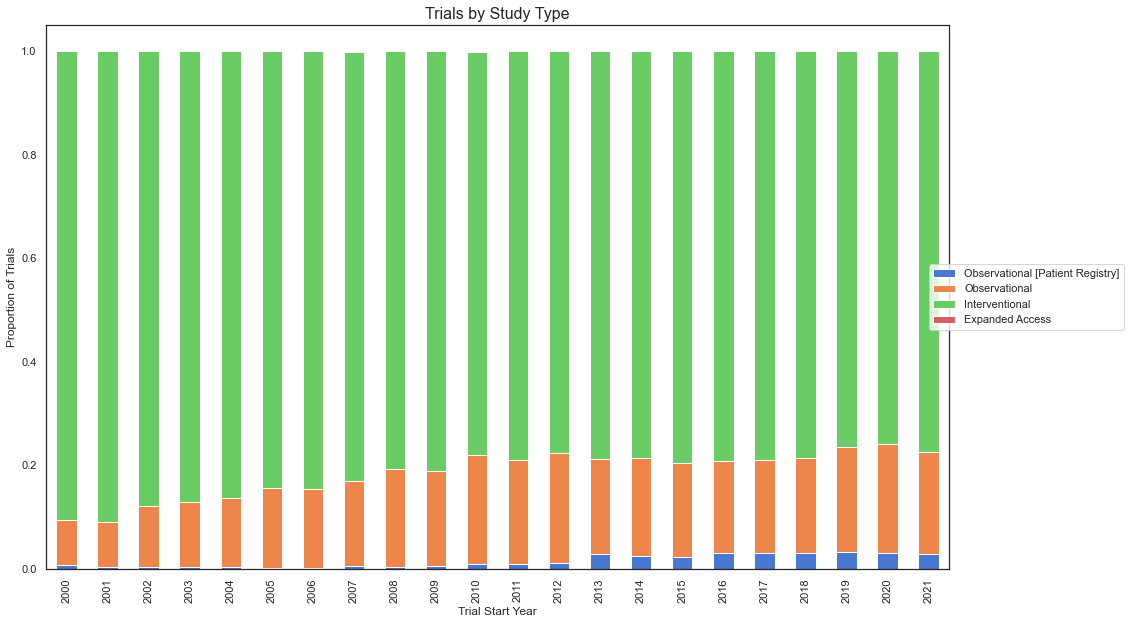

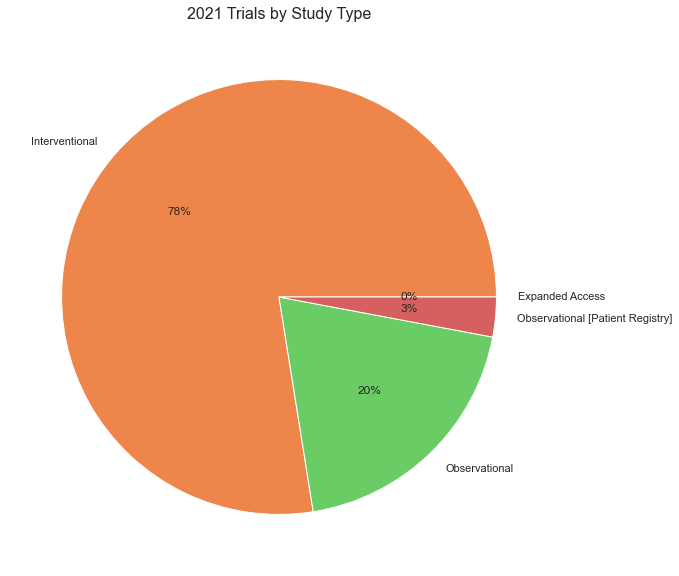

study_type,start_year,Expanded Access,Interventional,Observational,Observational [Patient Registry]
0,2000,0.000000,0.906389,0.086181,0.007429
1,2001,0.000000,0.909477,0.086280,0.004243
2,2002,0.000000,0.879391,0.117096,0.003513
3,2003,0.000000,0.871866,0.124420,0.003714
4,2004,0.000762,0.862148,0.134044,0.003046


In [568]:
df=annual_stacked_bar_100(onc_trials, colname='study_type', collabel="Study Type", reverse=True)
df.head()

['a) Early Phase 1',
 'b) Phase 1',
 'c) Phase 1/Phase 2',
 'd) Phase 2',
 'e) Phase 2/Phase 3',
 'e) Phase 3',
 'f) Phase 4',
 'g) Not Applicable',
 'h) Missing']

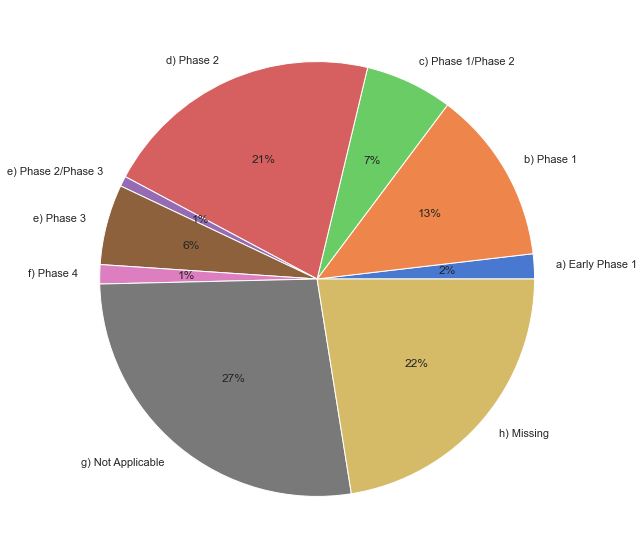

mapped_phase,start_year,a) Early Phase 1,b) Phase 1,c) Phase 1/Phase 2,d) Phase 2,e) Phase 2/Phase 3,e) Phase 3,f) Phase 4,g) Not Applicable,h) Missing
21,2021,78.0,542.0,273.0,879.0,32.0,251.0,60.0,1140.0,944.0


In [550]:
df.columns = df.columns.astype(str)
df.columns

Index(['start_year', 'True', 'False'], dtype='object', name='has_us_facility')

In [552]:
df['past_year_count_true'] = df['True'].shift(1)
df['yoy_perc_change_true']=df['True']/df['past_year_count_true']-1
df['past_year_count_false'] = df['False'].shift(1)
df['yoy_perc_change_false']=df['False']/df['past_year_count_false']-1
df.head()

has_us_facility,start_year,True,False,past_year_count_true,yoy_perc_change_true,past_year_count_false,yoy_perc_change_false
0,2000,500,173,NaN,NaN,NaN,NaN
1,2001,500,207,500.0,0.000000,173.0,0.196532
2,2002,560,294,500.0,0.120000,207.0,0.420290
3,2003,703,374,560.0,0.255357,294.0,0.272109
4,2004,846,467,703.0,0.203414,374.0,0.248663


In [555]:
print(df[df.start_year.dt.year<=2021].yoy_perc_change_true.mean())
print(df[df.start_year.dt.year<=2021].yoy_perc_change_false.mean())
df.tail()


0.05392684025726399
0.14597732141285713


has_us_facility,start_year,True,False,past_year_count_true,yoy_perc_change_true,past_year_count_false,yoy_perc_change_false
17,2017,1394,1927,1237.0,0.126920,1966.0,-0.019837
18,2018,1368,2203,1394.0,-0.018651,1927.0,0.143228
19,2019,1362,2306,1368.0,-0.004386,2203.0,0.046754
20,2020,1344,2389,1362.0,-0.013216,2306.0,0.035993
21,2021,1410,2789,1344.0,0.049107,2389.0,0.167434


In [556]:
df

has_us_facility,start_year,True,False,past_year_count_true,yoy_perc_change_true,past_year_count_false,yoy_perc_change_false
0,2000,500,173,NaN,NaN,NaN,NaN
1,2001,500,207,500.0,0.000000,173.0,0.196532
2,2002,560,294,500.0,0.120000,207.0,0.420290
3,2003,703,374,560.0,0.255357,294.0,0.272109
4,2004,846,467,703.0,0.203414,374.0,0.248663
5,2005,934,592,846.0,0.104019,467.0,0.267666
6,2006,1095,723,934.0,0.172377,592.0,0.221284
7,2007,1117,825,1095.0,0.020091,723.0,0.141079
8,2008,1089,975,1117.0,-0.025067,825.0,0.181818
9,2009,1166,993,1089.0,0.070707,975.0,0.018462


In [419]:
df['past_year_count'] = df['nct_id'].shift(1)
df['yoy_perc_change']=df.nct_id/df['past_year_count']-1
df.head()

KeyError: 'nct_id'

In [385]:
df[df.start_year.dt.year<=2020].yoy_perc_change.mean()

0.09206959266777796

In [386]:
df.tail()

,start_year,nct_id,past_year_count,yoy_perc_change
17,2017,3321,3203.0,0.036840
18,2018,3571,3321.0,0.075279
19,2019,3668,3571.0,0.027163
20,2020,3733,3668.0,0.017721
21,2021,4199,3733.0,0.124833


In [8]:
## Analyze trials by site country

In [109]:
# trial_sites=aq.query_aact(aq.get_cancer_trial_sites())
trial_sites=pd.read_csv("extract/extracted_data/cancer_trials_sites.csv", index_col=0)

/Users/forrest.xiao/miniconda3/envs/trialtrackerenv_py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning:

Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.



In [110]:
# trial_sites.to_csv("extract/extracted_data/cancer_trials_sites.csv", index=False)

In [111]:
trial_sites.columns

Index(['title', 'has_us_facility', 'start_date', 'overall_status', 'phase',
       'enrollment', 'enrollment_type', 'study_type', 'number_of_arms',
       'number_of_groups', 'why_stopped', 'has_dmc', 'is_fda_regulated_drug',
       'is_fda_regulated_device', 'is_unapproved_device', 'is_ppsd',
       'is_us_export', 'facility_id', 'facility_name', 'facility_status',
       'facility_city', 'facility_state', 'facility_zip', 'facility_country'],
      dtype='object')

In [112]:
ctgov_data_prep(trial_sites)

In [113]:
trial_sites['facility_country'].fillna('Null', inplace=True)

In [114]:
pc.countries.get(name='United States')

Country(alpha_2='US', alpha_3='USA', name='United States', numeric='840', official_name='United States of America')

In [115]:
trial_sites.facility_country.value_counts().head()

United States    343446
France            29947
Spain             19571
Germany           18929
China             18853
Name: facility_country, dtype: int64

In [116]:
def get_country_alpha_2(country_name):
    manual_map={'Taiwan':'TW',
               'Czech Republic':'CZ',
               'Vietnam':'VN',
               'Venezuela':'VE',
                'Tanzania':'TZ',
                'Macedonia':'MK',
                'Former Serbia and Montenegro':'CS',
                'Palestinian Territory, occupied':'PS',
                'Swaziland':'SZ',
                'Yugoslavia':'YU',
                'Bolivia':'BO',
                'Kosovo':'XK',
                'Virgin Islands (U.S.)':'VI'
               }
    try:
        alpha_2=pc.countries.get(name=country_name).alpha_2
    except:
        alpha_2=manual_map.get(country_name, 'Null')

    
    return alpha_2
    

In [117]:
def get_country_alpha_3(country_name):
    manual_map={'Taiwan':'TWN',
               'Czech Republic':'CZE',
               'Vietnam':'VNM',
               'Venezuela':'VEN',
                'Tanzania':'TZA',
                'Macedonia':'MKD',
                'Macedonia, The Former Yugoslav Republic of':'MKD',
                'Former Serbia and Montenegro':'SCG',
                'Palestinian Territory, occupied':'PSE',
                'Swaziland':'SWZ',
                'Yugoslavia':'YUG',
                'Former Yugoslavia':'YUG',
                'Bolivia':'BOL',
                'Kosovo':'XKX',
                'Virgin Islands (U.S.)':'VIR'
               }
    try:
        alpha_3=pc.countries.get(name=country_name).alpha_3
    except:
        alpha_3=manual_map.get(country_name, 'Null')

    
    return alpha_3

In [118]:
trial_sites['country_alpha_2']=trial_sites.facility_country.apply(lambda x: get_country_alpha_2(x))
trial_sites['country_alpha_3']=trial_sites.facility_country.apply(lambda x: get_country_alpha_3(x))

In [119]:
trial_sites[trial_sites['country_alpha_3']=='Null'].facility_country.value_counts()

Null    4443
Name: facility_country, dtype: int64

In [120]:
sites_df=trial_sites[trial_sites.start_datetime.dt.year==2021]['country_alpha_3'].value_counts().reset_index()
sites_df.columns=['country','values']
sites_df.describe()

,values
count,93.000000
mean,283.322581
std,1104.390213
min,1.000000
25%,3.000000
50%,35.000000
75%,133.000000
max,10135.000000


In [121]:
# tickvals = [2**x for x in range(0,20)]
# tickvals

In [122]:
import re

def camelize(string):
    output = ''.join(x for x in string.title() if x.isalnum())
    return output[0].lower() + output[1:]

def snakify(string):
    name=camelize(string)
    return re.sub(r'(?<!^)(?=[A-Z])', '_', name).lower()

print(snakify("Clinical Trial Site Count by Country: 2021"))

clinical_trial_site_count_by_country2021


In [123]:
def choropleth(df, year: int):

    sites_df=df[df.start_datetime.dt.year==year]['country_alpha_3'].value_counts().reset_index()
    sites_df.columns=['country','values']

    # df = px.data.gapminder().query("year==2007")
    fig = px.choropleth(sites_df, locations="country",
                        color=np.log10(sites_df["values"]), 
                        hover_name="country",
                        color_continuous_scale='Reds')

    # log https://community.plotly.com/t/how-to-make-a-logarithmic-color-scale-in-my-choropleth-map/35010/4
    fig.update_layout(coloraxis_colorbar=dict(len=0.75,
                      title='# of Trial-Sites', 
                      tickvals = [0, 1, 2, 3, 3.699, 4],
                      ticktext = ['1', '10', '100', '1000', '5000','10000'],                                  

    ),
                                              legend=dict(yanchor='middle', xanchor='right', x=3
        # bbox_to_anchor=(0.6,0.5)
        )   
                     
                     )
    
    title="Clinical Trial Site Count by Country: "+str(year)
    
    fig.update_layout(
        title={
            'text' : title,
            'x':0.5,
            'xanchor': 'center'
        }
        # geo_scope='usa', # limite map scope to USA
    )
    

    
    filename=snakify(title)+".png"
    
    filepath="./visuals/"+filename
    fig.write_image(filepath)

    # log transform colors
    # fig.update_geos(fitbounds="locations", visible=False)
    # fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    # fig.show()

    iplot(fig,validate=False, filename=filepath)
    
    return filepath
    # plot(fig, validate=False, filename='d3-world-map.html', image='png')

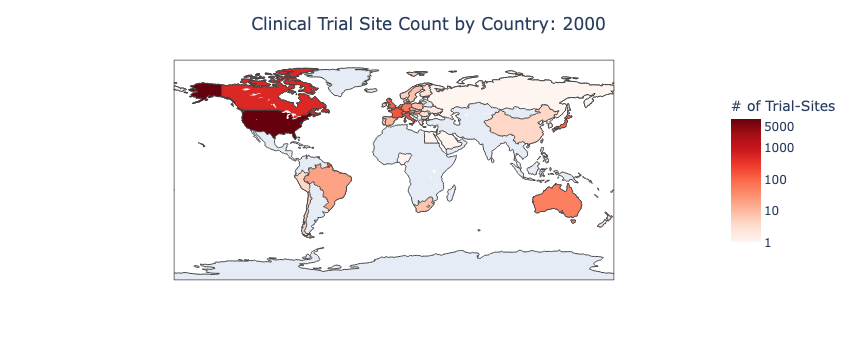

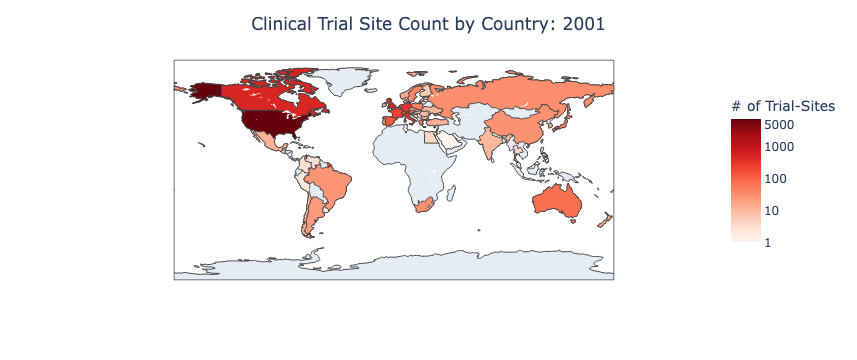

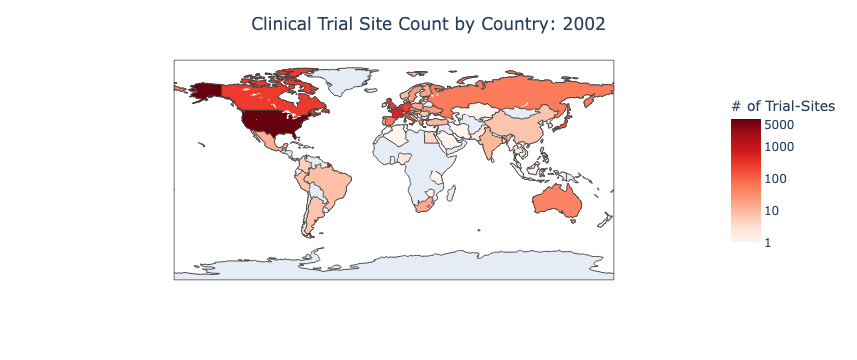

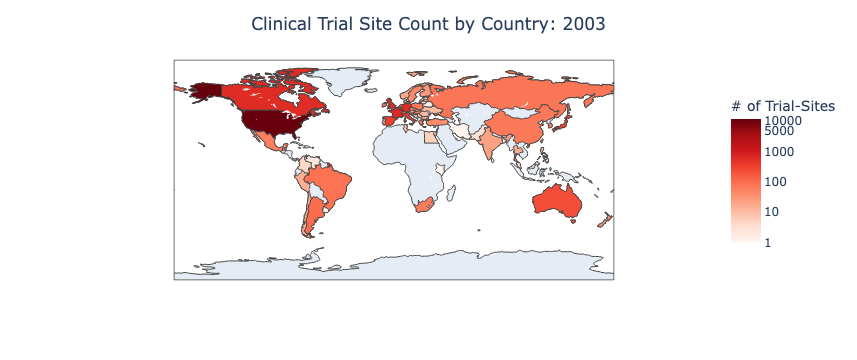

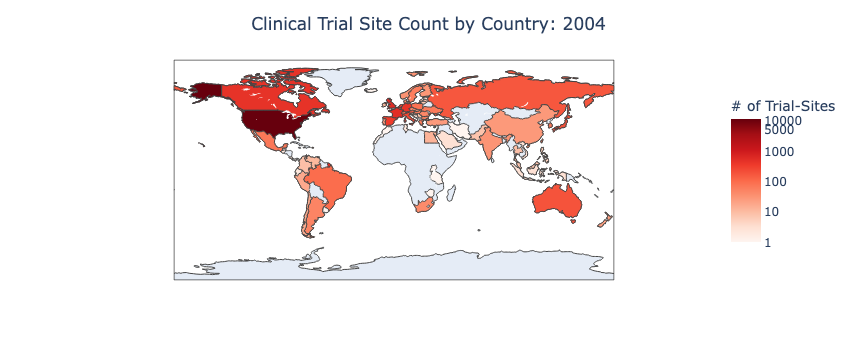

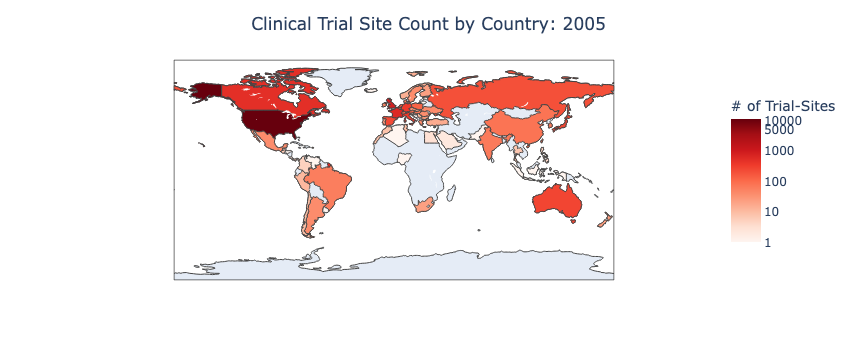

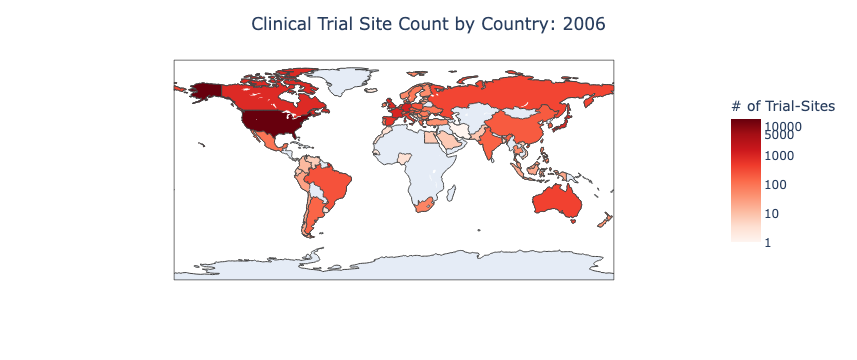

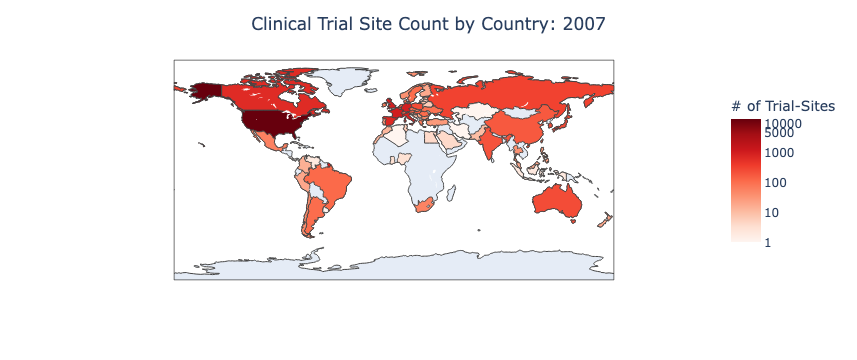

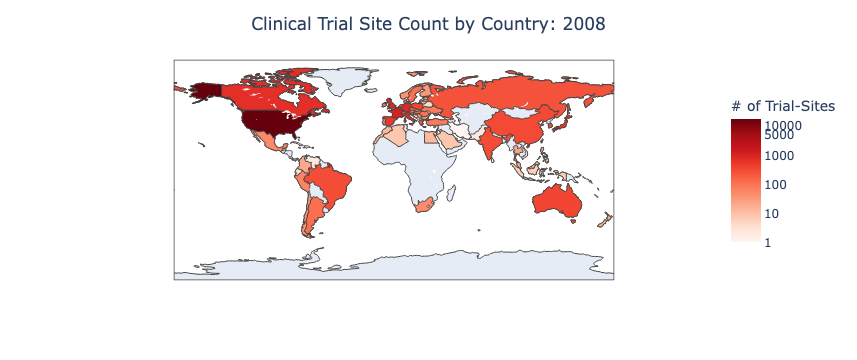

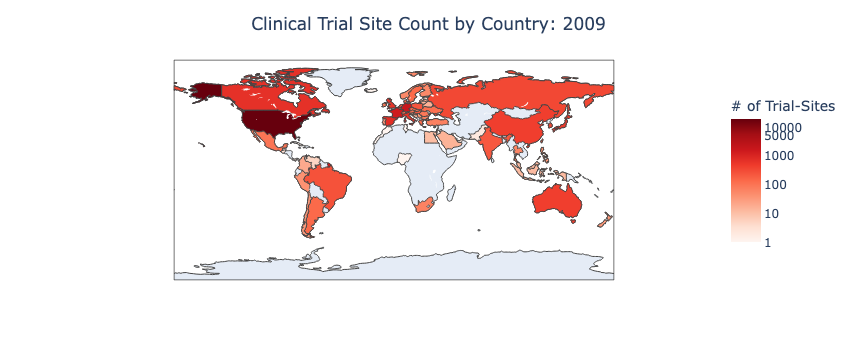

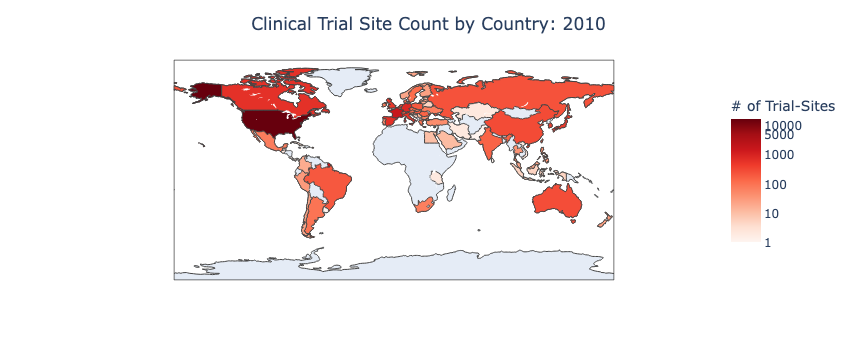

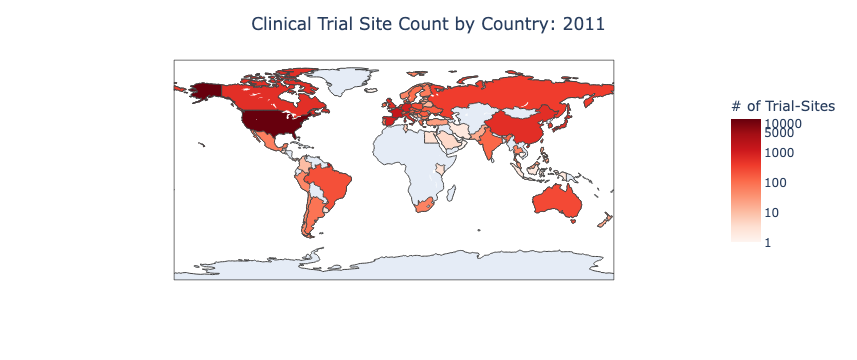

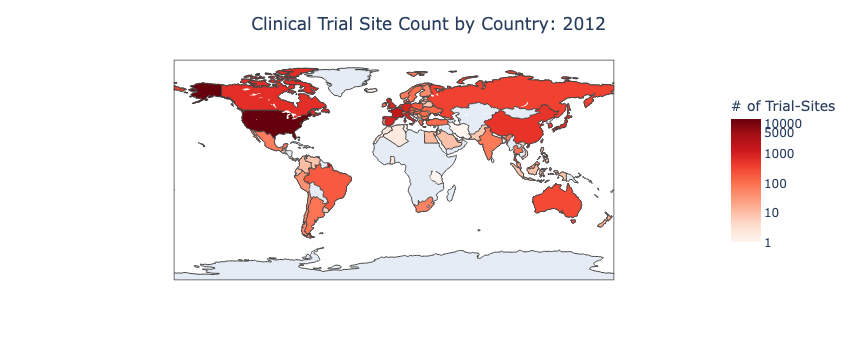

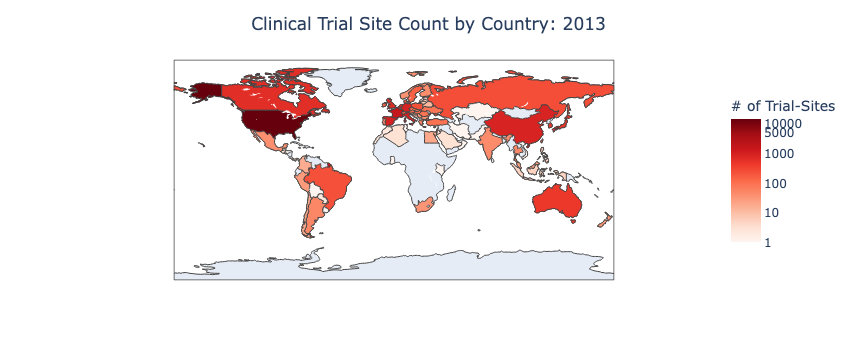

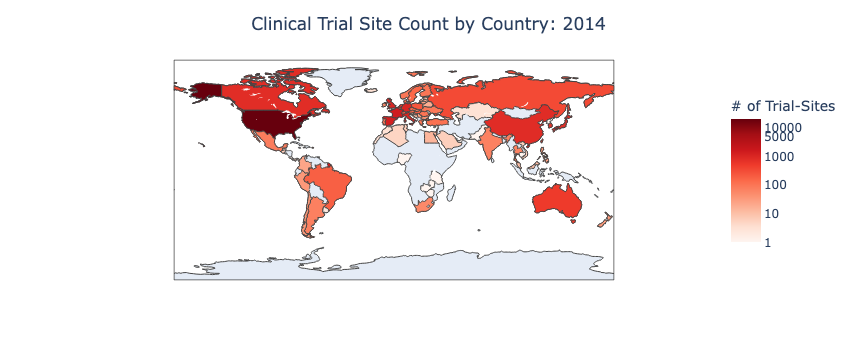

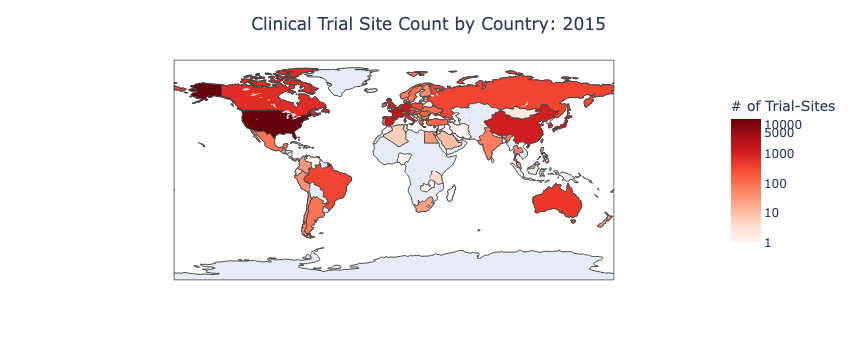

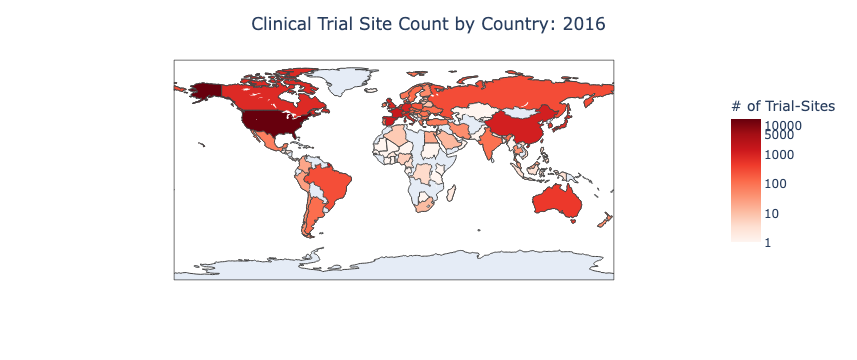

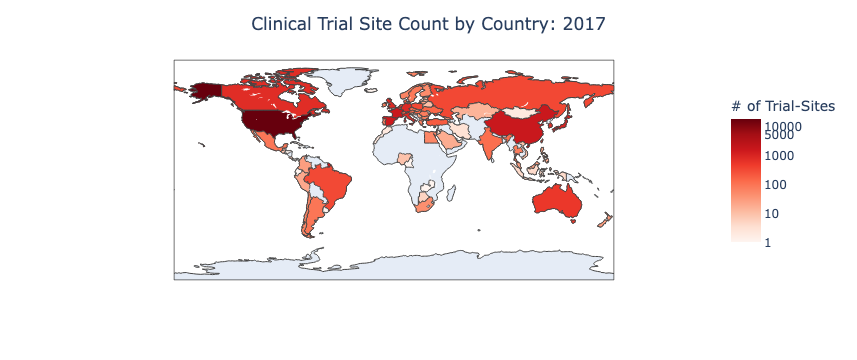

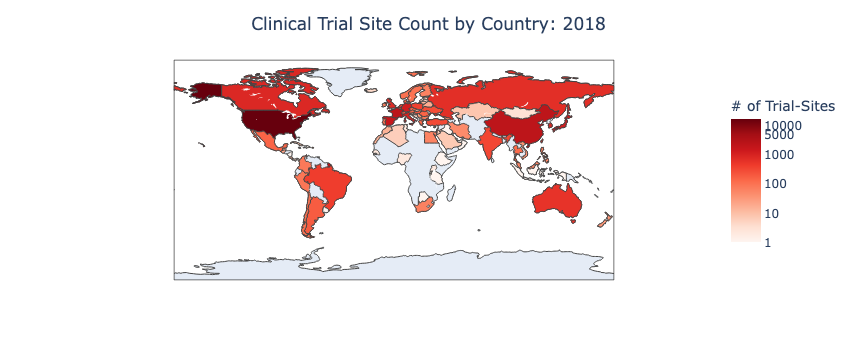

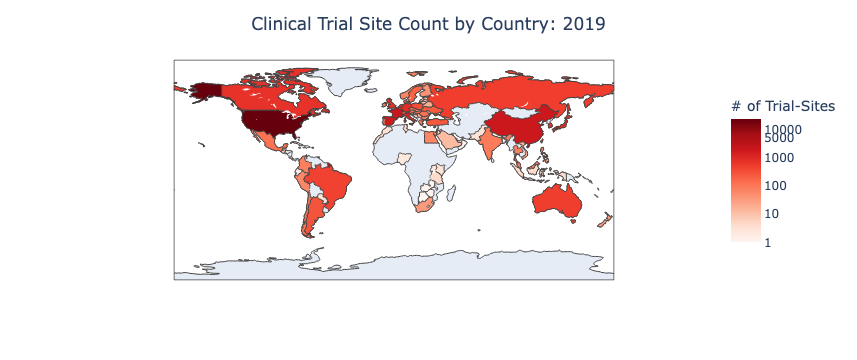

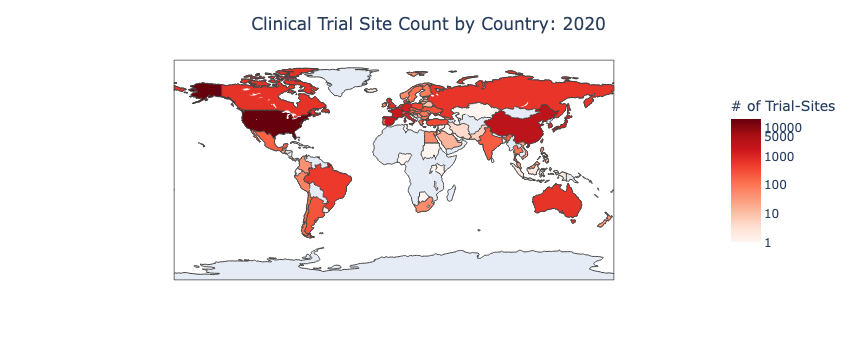

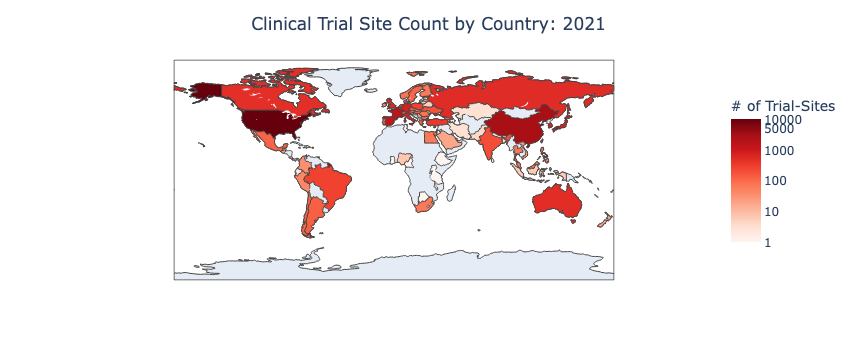

In [124]:
filenames=[]

for x in range(2000,2022):
    filenames.append(choropleth(trial_sites, x))

In [130]:
img_to_gif(filenames, './visuals/clinical_trial_site_count_by_country.gif')

In [20]:
trial_sites[trial_sites.facility_country!='United States'].head()

,nct_id,title,has_us_facility,start_date,overall_status,phase,enrollment,enrollment_type,study_type,number_of_arms,number_of_groups,why_stopped,has_dmc,is_fda_regulated_drug,is_fda_regulated_device,is_unapproved_device,is_ppsd,is_us_export,facility_id,facility_name,facility_status,facility_city,facility_state,facility_zip,facility_country,start_datetime,start_year
1,NCT00000124,Collaborative Ocular Melanoma Study (COMS),false,1986-11-30,Unknown status,Phase 3,NaN,None,Interventional,NaN,NaN,None,None,None,None,None,None,None,NaN,None,None,None,None,None,Null,1986-11-30,1986
2,NCT00000603,Cord Blood Stem Cell Transplantation Study (CO...,false,1996-09-30,Completed,Phase 2,NaN,None,Interventional,NaN,NaN,None,None,None,None,None,None,None,NaN,None,None,None,None,None,Null,1996-09-30,1996
3,NCT00000611,Women's Health Initiative (WHI),false,None,Completed,Phase 3,NaN,None,Interventional,NaN,NaN,None,None,None,None,None,None,None,NaN,None,None,None,None,None,Null,NaT,NaT
67,NCT00001469,Genetic Analysis of Hereditary Prostate Cancer,true,1995-01-01,Completed,None,7776.0,Actual,Observational,NaN,1.0,None,None,None,None,None,None,None,38208725.0,Tampere University,None,Tampere,None,None,Finland,1995-01-01,1995
121,NCT00001898,Microarray Analysis for Human Genetic Disease,true,1999-06-29,Completed,None,1500.0,None,Observational,NaN,NaN,None,None,None,None,None,None,None,38209024.0,Helsinki University Central Hospital,None,Helsinki,None,None,Finland,1999-06-29,1999


In [14]:
trial_sites.head()

,title,has_us_facility,start_date,overall_status,phase,enrollment,enrollment_type,study_type,number_of_arms,number_of_groups,why_stopped,has_dmc,is_fda_regulated_drug,is_fda_regulated_device,is_unapproved_device,is_ppsd,is_us_export,facility_id,facility_name,facility_status,facility_city,facility_state,facility_zip,facility_country,start_datetime,start_year
nct_id,,,,,,,,,,,,,,,,,,,,,,,,,,
NCT00000105,Vaccination With Tetanus and KLH to Assess Imm...,True,2002-07-31,Terminated,NaN,112.0,Actual,Observational,NaN,3.0,Replaced by another study.,True,NaN,NaN,NaN,NaN,NaN,38200201.0,"Division of Hematology, Oncology, and Transpla...",NaN,Minneapolis,Minnesota,55455,United States,2002-07-31,2002
NCT00000124,Collaborative Ocular Melanoma Study (COMS),False,1986-11-30,Unknown status,Phase 3,NaN,NaN,Interventional,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Null,1986-11-30,1986
NCT00000603,Cord Blood Stem Cell Transplantation Study (CO...,False,1996-09-30,Completed,Phase 2,NaN,NaN,Interventional,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Null,1996-09-30,1996
NCT00000611,Women's Health Initiative (WHI),False,NaN,Completed,Phase 3,NaN,NaN,Interventional,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Null,NaT,NaT
NCT00000764,Chemoprevention of Anal Neoplasia Arising Seco...,True,NaN,Completed,Phase 1,98.0,NaN,Interventional,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38202633.0,University of Washington AIDS CRS,NaN,Seattle,Washington,98122,United States,NaT,NaT


In [13]:
sites.head()

NameError: name 'sites' is not defined

In [403]:
#analyze eligibility criteria

In [569]:
onc_trials=pd.read_csv("extract/extracted_data/ct_fb_parser_data.csv", index_col=0)
onc_trials.head()

,#nct_id,title,has_us_facility,conditions,eligibility_criteria,start_date,lead_sponsor,summary,overall_status,phase,enrollment,enrollment_type,study_type,number_of_arms,number_of_groups,why_stopped,has_dmc,is_fda_regulated_drug,is_fda_regulated_device,is_unapproved_device,is_ppsd,is_us_export
0,NCT00000105,Vaccination With Tetanus and KLH to Assess Imm...,True,Cancer,Inclusion Criteria:\n\nPatients must have a di...,2002-07-31,"Masonic Cancer Center, University of Minnesota",The purpose of this study is to learn how the ...,Terminated,NaN,112.0,Actual,Observational,NaN,3.0,Replaced by another study.,True,NaN,NaN,NaN,NaN,NaN
1,NCT00000124,Collaborative Ocular Melanoma Study (COMS),False,Choroid Neoplasms|Uveitis,Men and women eligible for the study must be a...,1986-11-30,National Eye Institute (NEI),To evaluate therapeutic interventions for pati...,Unknown status,Phase 3,NaN,NaN,Interventional,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NCT00000603,Cord Blood Stem Cell Transplantation Study (CO...,False,"Anemia, Aplastic|Fanconi Anemia|Hematologic Di...",Mothers of Infant-donors must complete a medic...,1996-09-30,"National Heart, Lung, and Blood Institute (NHLBI)","To evaluate if HLA-mismatched, unrelated-donor...",Completed,Phase 2,NaN,NaN,Interventional,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NCT00000611,Women's Health Initiative (WHI),False,Bone Diseases|Breast Neoplasms|Cardiovascular ...,Postmenopausal women ages 50 to 79.,NaN,"National Heart, Lung, and Blood Institute (NHLBI)","To address cardiovascular disease, cancer, and...",Completed,Phase 3,NaN,NaN,Interventional,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NCT00000764,Chemoprevention of Anal Neoplasia Arising Seco...,True,Anus Neoplasms|HIV Infections,Inclusion Criteria\n\nConcurrent Medication:\n...,NaN,National Institute of Allergy and Infectious D...,"PRIMARY: In Phase I, to define a broadly toler...",Completed,Phase 1,98.0,NaN,Interventional,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df=annual_stacked_bar_100(onc_trials, colname='study_type', collabel="Study Type", reverse=True)
df.head()

In [572]:
onc_trials['#nct_id'].nunique()

54404

In [570]:
ct = pd.read_csv("./extract/extracted_data/ie_parsed_clinical_trials.tsv", sep='\t')


In [571]:
ct['#nct_id'].nunique()

48133

In [573]:
missing_nct_extraction = list(set(onc_trials['#nct_id'].tolist()) - set(ct['#nct_id'].tolist()))
print(len(missing_nct_extraction))

7176


In [579]:
inpt = pd.read_csv("./extract/src/github.com/facebookresearch/Clinical-Trial-Parser/data/input/clinical_trials_old.csv")

In [580]:
inpt.head()

,#nct_id,title,has_us_facility,conditions,eligibility_criteria
0,NCT04346355,Efficacy of Early Administration of Tocilizuma...,false,COVID-19 Pneumonia,\n Inclusion Criteria:\n\n - ...
1,NCT04344951,Chloroquine Phosphate Against Infection by the...,false,"Covid-19|Pneumonia, Viral",\n Inclusion Criteria:\n\n - ...
2,NCT04344444,Treatment in Patients With Suspected or Confir...,true,COVID-19,\n Inclusion Criteria:\n\n - ...
3,NCT04344080,Effect of CytoSorb Adsorber on Hemodynamic and...,false,COVID-19,\n Inclusion Criteria:\n\n - ...
4,NCT04344015,COVID-19 Plasma Collection,true,COVID-19,\n Inclusion Criteria:\n\n - ...


In [577]:
supplemental_extraction_df=onc_trials[onc_trials['#nct_id'].isin(missing_nct_extraction)]
supplemental_extraction_df.head()

,#nct_id,title,has_us_facility,conditions,eligibility_criteria,start_date,lead_sponsor,summary,overall_status,phase,enrollment,enrollment_type,study_type,number_of_arms,number_of_groups,why_stopped,has_dmc,is_fda_regulated_drug,is_fda_regulated_device,is_unapproved_device,is_ppsd,is_us_export
1,NCT00000124,Collaborative Ocular Melanoma Study (COMS),False,Choroid Neoplasms|Uveitis,Men and women eligible for the study must be a...,1986-11-30,National Eye Institute (NEI),To evaluate therapeutic interventions for pati...,Unknown status,Phase 3,NaN,NaN,Interventional,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NCT00000603,Cord Blood Stem Cell Transplantation Study (CO...,False,"Anemia, Aplastic|Fanconi Anemia|Hematologic Di...",Mothers of Infant-donors must complete a medic...,1996-09-30,"National Heart, Lung, and Blood Institute (NHLBI)","To evaluate if HLA-mismatched, unrelated-donor...",Completed,Phase 2,NaN,NaN,Interventional,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NCT00000611,Women's Health Initiative (WHI),False,Bone Diseases|Breast Neoplasms|Cardiovascular ...,Postmenopausal women ages 50 to 79.,NaN,"National Heart, Lung, and Blood Institute (NHLBI)","To address cardiovascular disease, cancer, and...",Completed,Phase 3,NaN,NaN,Interventional,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NCT00001158,Studies of the Immune Response in Normal Subje...,True,Immunologic Deficiency Syndromes|Neoplasms,Patients will be studied if a disorder of the ...,1977-04-30,National Cancer Institute (NCI),The goal of the protocol is to define the norm...,Completed,NaN,NaN,NaN,Observational,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,NCT00001189,"The Treatment of Grade I Sarcomas and Benign, ...",True,Neoplasms|Sarcoma,DISEASE CHARACTERISTICS:\n\nBiopsy-proven grad...,1983-12-31,National Cancer Institute (NCI),Patients with Grade I soft tissue sarcomas or ...,Completed,Phase 2,150.0,NaN,Interventional,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [587]:
supplemental_extraction_df.iloc[:, :5].head()

,#nct_id,title,has_us_facility,conditions,eligibility_criteria
1,NCT00000124,Collaborative Ocular Melanoma Study (COMS),False,Choroid Neoplasms|Uveitis,Men and women eligible for the study must be a...
2,NCT00000603,Cord Blood Stem Cell Transplantation Study (CO...,False,"Anemia, Aplastic|Fanconi Anemia|Hematologic Di...",Mothers of Infant-donors must complete a medic...
3,NCT00000611,Women's Health Initiative (WHI),False,Bone Diseases|Breast Neoplasms|Cardiovascular ...,Postmenopausal women ages 50 to 79.
6,NCT00001158,Studies of the Immune Response in Normal Subje...,True,Immunologic Deficiency Syndromes|Neoplasms,Patients will be studied if a disorder of the ...
13,NCT00001189,"The Treatment of Grade I Sarcomas and Benign, ...",True,Neoplasms|Sarcoma,DISEASE CHARACTERISTICS:\n\nBiopsy-proven grad...


In [589]:
supplemental_extraction_df[supplemental_extraction_df['#nct_id']=='NCT00000124'].head()

,#nct_id,title,has_us_facility,conditions,eligibility_criteria,start_date,lead_sponsor,summary,overall_status,phase,enrollment,enrollment_type,study_type,number_of_arms,number_of_groups,why_stopped,has_dmc,is_fda_regulated_drug,is_fda_regulated_device,is_unapproved_device,is_ppsd,is_us_export
1,NCT00000124,Collaborative Ocular Melanoma Study (COMS),False,Choroid Neoplasms|Uveitis,Men and women eligible for the study must be a...,1986-11-30,National Eye Institute (NEI),To evaluate therapeutic interventions for pati...,Unknown status,Phase 3,NaN,NaN,Interventional,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [591]:
supplemental_extraction_df.iloc[:, :5].to_csv("extract/src/github.com/facebookresearch/Clinical-Trial-Parser/data/input/clinical_trials.csv", index=False)
supplemental_extraction_df.shape

(7176, 22)

In [401]:
ct.rename(columns={'#nct_id':'nct_id'}, inplace=True)
ct.head()

,nct_id,eligibility_type,criterion,label,term,ner_score,concepts,tree_numbers,nel_score
0,NCT00030264,inclusion,"Progressive, debilitating, severely disfigurin...",word_scores:cancer,tumor,0.850,Neoplasms,C04,1.0
1,NCT00030264,inclusion,"Progressive, debilitating, severely disfigurin...",word_scores:cancer,tumor must,0.769,NaN,NaN,NaN
2,NCT00030264,inclusion,"Progressive, debilitating, severely disfigurin...",word_scores:treatment,therapy,0.760,Therapeutics,E02,1.0
3,NCT00030264,inclusion,or more café-au-lait spots > 0.5 cm in prepube...,word_scores:clinical_variable,café-au-lait spots,0.845,NaN,NaN,NaN
4,NCT00030264,inclusion,"Adequate bone marrow, renal, hepatic function",word_scores:chronic_disease,renal hepatic function,0.807,Kidney,A05.810.453,1.0


In [418]:
ct.concepts.value_counts(normalize=True).head(40)
#TODO: check what proportion of trials contain each term, ie ECOG

Women                             0.063121
Therapeutics                      0.057018
Pregnancy                         0.036463
Cancer                            0.028253
Drug Therapy                      0.024273
Men                               0.019582
Radiotherapy                      0.015020
Bilirubin                         0.013900
Radiation|Radiotherapy            0.012491
ECOG                              0.012150
Neoplasms                         0.011599
Myocardial Infarction             0.011501
Congestive Heart Failure          0.011429
Breast Cancer                     0.010787
Angina, Unstable                  0.010636
Brain Cancer|Brain Metastases     0.010354
Life Expectancy                   0.008883
Hepatitis B                       0.008134
Arrhythmias, Cardiac              0.008078
Pregnancy Tests                   0.007916
Hemoglobin E|Hemoglobins          0.007810
HIV                               0.007394
Hepatitis C                       0.006903
Autoimmune 

In [7]:
onc_trials['matches'] = ct['names'].apply(lambda x: process.extractOne(x, group['names'].to_list()))

NameError: name 'ct' is not defined

54404 cancer trials.


In [37]:
onc_trials.columns

Index(['nct_id', 'title', 'has_us_facility', 'conditions',
       'eligibility_criteria', 'start_date', 'lead_sponsor', 'summary',
       'overall_status', 'phase', 'enrollment', 'enrollment_type',
       'study_type', 'number_of_arms', 'number_of_groups', 'why_stopped',
       'has_dmc', 'is_fda_regulated_drug', 'is_fda_regulated_device',
       'is_unapproved_device', 'is_ppsd', 'is_us_export'],
      dtype='object')

In [93]:
breakdown(onc_trials, "phase")

,phase,study_count,study_percent
0,Phase 2,13283,0.304866
1,Not Applicable,11757,0.269842
2,Phase 1,8162,0.187331
3,Phase 3,4547,0.104361
4,Phase 1/Phase 2,3467,0.079573
5,Phase 4,1063,0.024398
6,Early Phase 1,681,0.015630
7,Phase 2/Phase 3,610,0.014000


In [97]:
breakdown(onc_trials, "study_type")

,study_type,study_count,study_percent
0,Interventional,43571,0.800879
1,Observational,9654,0.177450
2,Observational [Patient Registry],1019,0.018730
3,Expanded Access,160,0.002941


In [98]:
breakdown(onc_trials, "overall_status")

,overall_status,study_count,study_percent
0,Completed,23604,0.433865
1,Recruiting,10866,0.199728
2,Unknown status,6471,0.118943
3,Terminated,4555,0.083725
4,"Active, not recruiting",3987,0.073285
5,Not yet recruiting,2502,0.045989
6,Withdrawn,1694,0.031137
7,Enrolling by invitation,322,0.005919
8,Suspended,243,0.004467
9,No longer available,75,0.001379


In [99]:
breakdown(onc_trials, "why_stopped")

,why_stopped,study_count,study_percent
0,Slow accrual,127,0.023167
1,low accrual,78,0.014228
2,slow accrual,74,0.013499
3,Low accrual,64,0.011675
4,Poor accrual,44,0.008026
...,...,...,...
4013,The CYPRESS-2 trial was closed early after the...,1,0.000182
4014,Identical study Biomed 777-CLP-029 did not mee...,1,0.000182
4015,Administrative reasons.,1,0.000182
4016,The PI is dealing with recurrent cancer and mu...,1,0.000182


In [100]:
breakdown(onc_trials, "is_fda_regulated_drug")

,is_fda_regulated_drug,study_count,study_percent
0,False,17286,0.714357
1,True,6912,0.285643


In [101]:
breakdown(onc_trials, "is_fda_regulated_device")

,is_fda_regulated_device,study_count,study_percent
0,False,23136,0.956626
1,True,1049,0.043374


In [127]:
## Sponsor Mapping

In [128]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

In [222]:
sponsor_match_dict={
    "AbbVie":{"type":"Pharma"},
    "Amgen":{"type":"Pharma"},
    "M.D. Anderson Cancer Center":{"type":"Cancer Center"},
    "Memorial Sloan Kettering Cancer Center":{"type":"Cancer Center"},
    "Roche":{"type":"Pharma"},
    "Novartis":{"type":"Pharma"},
    "Roche":{"type":"Pharma"},
    "Mayo":{"type":"Academic Medical Center","formal_name":"Mayo Clinic"},
    "Eli Lilly":{"type":"Pharma"},
    "Dana-Farber":{"type":"Cancer Center"},
    "Pfizer":{"type":"Pharma"},
    "Mass General":{"type":"Academic Medical Center"},
    "Bristol-Myers Squibb":{"type":"Pharma"},
    "AstraZeneca":{"type":"Pharma"},
    "Bayer":{"type":"Pharma"},
    "Boehringer Ingelheim":{"type":"Biotech"},
    "EQRx":{"type":"Biotech"},
    "Gilead":{"type":"Biotech"},
    "Sanofi":{"type":"Pharma"},
    "GlaxoSmithKline":{"type":"Pharma"},
    "ImmunoGen":{"type":"Biotech"},
    "Janssen":{"type":"Pharma"},
    "Merck":{"type":"Pharma"},
    "OneOncology":{"type":"Health System"},
    "Genentech":{"type":"Biotech"},
    "Takeda":{"type":"Pharma"},
    "University":{"type":"University"},
    
    
    "National Heart, Lung, and Blood Institute":{"type":"Government"},
    "National Cancer Institute":{"type":"Government"},
    "National":{"type":"Government"},
    "National Institute":{"type":"Government"},
    "Cancer Center":{"type":"Cancer Center"},
    "Oncology Group":{"type":"Oncology Group"},
    "St. Vincent Medical Center - Los Angeles":{"type":"Hospital"},
    "Medical Center":{"type":"Hospital"},
                                                
    "Shenzhen SiBiono GeneTech Co.,Ltd":{"type":"Biotech"},
    "European Organisation for Research and Treatment of Cancer - EORTC":{"type":"Government"},
    "Cancer Research UK":{"type":"Research Group"},

    "ECOG-ACRIN Cancer Research Group":{"type":"Research Group"},
    "Swiss Group for Clinical Cancer Research":{"type":"Research Group"},
    "Research Group":{"type":"Research Group"},
    "Cancer Research":{"type":"Research Group"},
    "General Hospital":{"type":"Hospital"},
    
    "University of Rochester":{"type":"University"},
    "Li Liu":{"type":"Individual"},
    "BioLeaders Corporation":{},
    "Regionalt Cancercentrum Väst":{},
    "Centre Hospitalier d'Abbeville":{},
    "Nanjing Leads Biolabs Co.,Ltd":{},
    "NRG Oncology":{},
    "Immunicon":{},
    
}
### LOOK INTO WHETHER CT.GOV HAS SPONSOR TYPE ALREADY!!!

In [7]:
sponsor_df=pd.DataFrame(sponsor_match_dict).transpose()
sponsor_df.head()

NameError: name 'sponsor_match_dict' is not defined

In [202]:
breakdown(onc_trials, "lead_sponsor").head()

,lead_sponsor,study_count,study_percent
0,National Cancer Institute (NCI),1959,0.036008
1,M.D. Anderson Cancer Center,1371,0.025200
2,Memorial Sloan Kettering Cancer Center,1052,0.019337
3,Hoffmann-La Roche,553,0.010165
4,AstraZeneca,491,0.009025


In [203]:
onc_trials['matches'] = onc_trials['lead_sponsor'].apply(lambda x: process.extractOne(x, sponsor_df.index.tolist()))

In [204]:
onc_trials['sponsor_name_match']=onc_trials.matches.apply(lambda x: x[0])
onc_trials['sponsor_match_score']=onc_trials.matches.apply(lambda x: x[1])

In [205]:
onc_trials[['lead_sponsor','sponsor_name_match','sponsor_match_score']][onc_trials.sponsor_match_score==86].iloc[0].lead_sponsor

'Mid-Atlantic Oncology Program'

In [215]:
onc_trials[['lead_sponsor','sponsor_name_match','sponsor_match_score']][onc_trials.sponsor_match_score==78].lead_sponsor.value_counts()

NRG Oncology                              27
Immunicon                                  2
Associazione Progetto Oncologia UMAN.A     1
Name: lead_sponsor, dtype: int64

In [207]:
onc_trials[['lead_sponsor','sponsor_name_match','sponsor_match_score']][onc_trials.sponsor_match_score>=75].shape[0]/onc_trials.shape[0]

0.7158480994044556

In [218]:
onc_trials[['lead_sponsor','sponsor_name_match','sponsor_match_score']].sponsor_name_match.value_counts().head(10)

University                                16115
Roche                                      3083
National Cancer Institute                  2749
Cancer Center                              2705
M.D. Anderson Cancer Center                2334
Medical Center                             2279
Oncology Group                             2044
National                                   2021
Memorial Sloan Kettering Cancer Center     1893
National Institute                         1298
Name: sponsor_name_match, dtype: int64

In [220]:
onc_trials[['lead_sponsor','sponsor_name_match','sponsor_match_score']][(onc_trials.sponsor_name_match=='Roche')&(onc_trials.sponsor_match_score>=75)].lead_sponsor.value_counts()

Hoffmann-La Roche          553
University of Rochester     89
Name: lead_sponsor, dtype: int64

In [136]:
onc_trials.head()

,nct_id,title,has_us_facility,conditions,eligibility_criteria,start_date,lead_sponsor,summary,overall_status,phase,enrollment,enrollment_type,study_type,number_of_arms,number_of_groups,why_stopped,has_dmc,is_fda_regulated_drug,is_fda_regulated_device,is_unapproved_device,is_ppsd,is_us_export,matches,sponsor_name_match,sponsor_match_score
0,NCT00000105,Vaccination With Tetanus and KLH to Assess Imm...,True,Cancer,Inclusion Criteria:\n\nPatients must have a di...,2002-07-31,"Masonic Cancer Center, University of Minnesota",The purpose of this study is to learn how the ...,Terminated,NaN,112.0,Actual,Observational,NaN,3.0,Replaced by another study.,True,NaN,NaN,NaN,NaN,NaN,"(University, 90)",University,90
1,NCT00000124,Collaborative Ocular Melanoma Study (COMS),False,Choroid Neoplasms|Uveitis,Men and women eligible for the study must be a...,1986-11-30,National Eye Institute (NEI),To evaluate therapeutic interventions for pati...,Unknown status,Phase 3,NaN,NaN,Interventional,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(Novartis, 45)",Novartis,45
2,NCT00000603,Cord Blood Stem Cell Transplantation Study (CO...,False,"Anemia, Aplastic|Fanconi Anemia|Hematologic Di...",Mothers of Infant-donors must complete a medic...,1996-09-30,"National Heart, Lung, and Blood Institute (NHLBI)","To evaluate if HLA-mismatched, unrelated-donor...",Completed,Phase 2,NaN,NaN,Interventional,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(Novartis, 53)",Novartis,53
3,NCT00000611,Women's Health Initiative (WHI),False,Bone Diseases|Breast Neoplasms|Cardiovascular ...,Postmenopausal women ages 50 to 79.,NaN,"National Heart, Lung, and Blood Institute (NHLBI)","To address cardiovascular disease, cancer, and...",Completed,Phase 3,NaN,NaN,Interventional,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(Novartis, 53)",Novartis,53
4,NCT00000764,Chemoprevention of Anal Neoplasia Arising Seco...,True,Anus Neoplasms|HIV Infections,Inclusion Criteria\n\nConcurrent Medication:\n...,NaN,National Institute of Allergy and Infectious D...,"PRIMARY: In Phase I, to define a broadly toler...",Completed,Phase 1,98.0,NaN,Interventional,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(AstraZeneca, 47)",AstraZeneca,47


In [113]:
## New function to plot distributions as time-series.  Maybe top 5 only over time.  Total num version and relative percent stacked chared

In [112]:
"2002-07-31".left(4)

AttributeError: 'str' object has no attribute 'left'

In [108]:
onc_trials[['nct_id','start_date']].dropna().head(20)
onc_trials['year']=onc_tri

,nct_id,start_date
0,NCT00000105,2002-07-31
1,NCT00000124,1986-11-30
2,NCT00000603,1996-09-30
5,NCT00001150,1976-10-31
6,NCT00001158,1977-04-30
7,NCT00001160,1977-06-01
8,NCT00001163,1985-04-02
9,NCT00001165,1978-09-30
10,NCT00001167,1979-08-31
11,NCT00001171,1979-07-31


In [43]:
## Compare document links with queried trials

In [7]:
doc_json=eda.read_doc_links()

In [ ]:
len(doc_json)

In [8]:
len(doc_json)

17547

In [11]:
doc_items = list(doc_json.items())

In [15]:
doc_df = pd.DataFrame(doc_json).transpose()

In [16]:
doc_df.head()

,PROT,ICF,SAP
NCT00000105,NaN,NaN,NaN
NCT00000124,NaN,NaN,NaN
NCT00000603,NaN,NaN,NaN
NCT00000611,NaN,NaN,NaN
NCT00000764,NaN,NaN,NaN


In [17]:
doc_df[~doc_df['PROT'].isna()].PROT.shape[0]

16

In [18]:
 doc_df[~doc_df['ICF'].isna()].ICF.shape[0]

3

In [19]:
doc_df[~doc_df['SAP'].isna()].SAP.shape[0]

1